In [1]:
import os
import glob
from read_images_main import *
%matplotlib inline 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time
import pickle
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [2]:
cars, notcars = read_images_data()

Number of cars =  8792
Number of non-cars =  8968


In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
def extract_features(imgs,spatial_size=(32, 32),hist_bins=32, orient=9,pix_per_cell=8,cell_per_block=2):    
    #1) Define an empty list to receive features
    features = []
    count = 0
    print ("total images to train = ", len(imgs))
    #2) Apply color conversion if other than 'RGB'
    for file in imgs:
        file_features = []
        img = mpimg.imread(file)
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)

        #plt.bar(range(len(spatial_features)), spatial_features, color="blue")
        #plt.show()
        file_features.append(spatial_features)
        
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #plt.bar(range(len(hist_features)), hist_features, color = 'green')
        #plt.show()
        file_features.append(hist_features)
        
        hog_features = []
        for channel in range(3):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))  
        hog_features = np.ravel(hog_features)
        #plt.bar(range(len(hog_features)), hog_features, color = 'pink')
        #plt.show()
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        #plt.bar(range(len(features[0])), features[0], color='blue')
        #plt.show()
        count = count +1
        if count % 1000 == 0:
            print ("trained images = ",count)
    return features

In [5]:
#to train decides to use saved model or train the classifier
if os.path.isfile("models/train_model.p"):
    print ("Saved model present")
    to_train = 0
else:
    print ("Train the classifier")
    to_train = 1

Saved model present


In [6]:
#Training of LSVM
orient_val = 9
pix_per_cell_val = 8
cell_per_block_val = 2
spatial_size_val = (32,32)
hist_bins_val = 32
t = time.time()
if to_train == 1:
    n_samples = 10000
else:
    n_samples = 10
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]
car_features = extract_features(test_cars, spatial_size=spatial_size_val, hist_bins= hist_bins_val,
                        orient=orient_val, pix_per_cell =pix_per_cell_val, cell_per_block = cell_per_block_val)

not_car_features = extract_features(test_notcars, spatial_size=spatial_size_val, hist_bins= hist_bins_val,
                        orient=orient_val, pix_per_cell =pix_per_cell_val, cell_per_block = cell_per_block_val)

print (time.time() - t, 'Seconds to compute features')


total images to train =  10
total images to train =  10
0.5808970928192139 Seconds to compute features


In [7]:
X = np.vstack((car_features, not_car_features)).astype(np.float64)
X_scalar = StandardScaler().fit(X)
scaledX = X_scalar.transform(X)


y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
rand_state = np.random.randint(0,100)

if to_train == 1:
    split_size = 0.1
else:
    split_size = 0.9
X_train, X_test, y_train, y_test = train_test_split(scaledX, y, test_size = split_size, random_state = rand_state)
print ("Using", orient_val, " orientations", 'pix_per_cell', pix_per_cell_val, 'cell_per_block', cell_per_block_val
      , "hist_bins", hist_bins_val, "and spatial_size", spatial_size_val)

print ('Feature vector length;', len(X_train[0]))

Using 9  orientations pix_per_cell 8 cell_per_block 2 hist_bins 32 and spatial_size (32, 32)
Feature vector length; 8460


In [8]:
if to_train == 1:
    t = time.time()
    svc=LinearSVC()
    t = time.time()
    svc.fit(X_train, y_train)
    print (round(time.time()-t,2), 'sec to train')
    acc = round(svc.score(X_test, y_test),4)
    print ("Test accuracy is", acc)

In [9]:
if to_train == 1:
    #save the model here 
    train_model_file = "./models/train_model.p" 
    output = open(train_model_file, 'wb')
    pickle.dump(svc, output)
    output.close()

In [10]:
if to_train == 0:
    trained_model_file = "./models/train_model.p"
    with open(trained_model_file, mode='rb') as f:
        svc = pickle.load(f)

In [11]:
acc1 = round(svc.score(X_test, y_test),4)
print ("Test accuracy is", acc1)

Test accuracy is 1.0


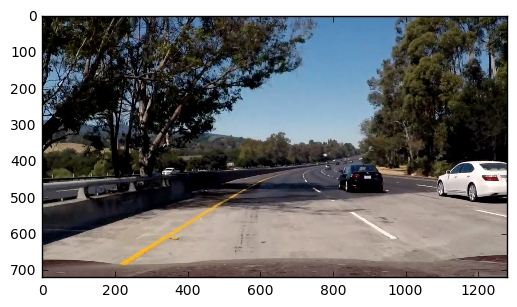

In [12]:
image = mpimg.imread("test_images/test5.jpg")
plt.imshow(image)
plt.show()

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    all_box = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
        all_box.append(bbox)
    # Return the image
    return img, all_box

In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    scale_choose = [1.3, 1.5, 1.8]
    draw_img = np.copy(img)
    count_window = 0
    ystart = 400
    ystop = 720
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    for scale in scale_choose:
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        if scale == 1.8:
            cells_per_step = 3
        else:
            cells_per_step = 2
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scalar.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                count_window += 1
        if vehicle_detected.first_frame == True:
            print ("For scale = ", scale, "no of windows = ", count_window)
        count_window = 0
    return draw_img, heatmap

In [15]:
class Car():
    def __init__(self):
        #Previous frames heatmaps
        self.heatmap = np.array([None]*10)
        #first frame 
        self.first_frame = True
        self.smoothened = 10
global vehicle_detected
vehicle_detected = Car()

In [16]:
def process_image(image):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32,32)
    hist_bins = 32
    out_img, heatmap = find_cars(image, svc, X_scalar, orient,
                        pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if vehicle_detected.first_frame == True:
        applied_threshold = apply_threshold(np.copy(heatmap), 1)
        #make the history same as the first frame
        vehicle_detected.heatmap = np.array([applied_threshold] * vehicle_detected.smoothened)
        vehicle_detected.first_frame = False
        labels = label(applied_threshold)
    else:    
        #look into previous frames   
        vehicle_detected.heatmap[0:-1] = vehicle_detected.heatmap[1:]
        vehicle_detected.heatmap[-1] = heatmap
        new_previous_frame_threshold = vehicle_detected.heatmap.sum(axis=0)
        #print(np.max(new_previous_frame_threshold))
        #plt.imshow(new_previous_frame_threshold)
        #plt.show()
        applied_threshold = apply_threshold(np.copy(new_previous_frame_threshold), vehicle_detected.smoothened*2+5)
        labels = label(applied_threshold)
        
    draw_labeled, bbox = draw_labeled_bboxes(np.copy(image), labels)
    #bias the position of the detected region by adding +1 to it
    #print (bbox)
    vehicle_detected.heatmap[-1] = add_heat(vehicle_detected.heatmap[-1], bbox)
    #plt.imshow(draw_labeled)
    #plt.show()
    return draw_labeled

In [17]:
white_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,46)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


For scale =  1.3 no of windows =  627
For scale =  1.5 no of windows =  441
For scale =  1.8 no of windows =  104
[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [1:00:40<00:02,  2.88s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 2h 8min 26s, sys: 3min 6s, total: 2h 11min 32s
Wall time: 1h 43s


In [18]:

HTML("""
<video width="900" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))